In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, 
import os

In [25]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [26]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
# Data Visualization
import plotly.express as px

In [28]:
import sys
from tqdm import tqdm
import time
import copy

In [29]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [30]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            #T.RandomHorizontalFlip(),
            #T.RandomVerticalFlip(),
            #T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
           # T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/taste2/Tumor Cellularity Dataset/20X_ROIs/Test/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/taste2/Tumor Cellularity Dataset/20X_ROIs/Test/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/taste2/Tumor Cellularity Dataset/20X_ROIs/Test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [31]:
dataset_path = "/kaggle/input/taste2/Tumor Cellularity Dataset/20X_ROIs/Test/"

In [32]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 16, train=False)

In [33]:
classes = get_classes("/kaggle/input/taste2/Tumor Cellularity Dataset/20X_ROIs/Test/")

In [34]:
# Get Class Names
class_names = sorted(os.listdir(dataset_path))
n_classes = len(class_names)

# Show
print(f"Class Names : {class_names}")
print(f"Number of Classes  : {n_classes}")

Class Names : ['blue', 'green', 'pink', 'yellow']
Number of Classes  : 4


In [35]:
# Calculate class distribution
class_dis = [len(os.listdir(dataset_path + name)) for name in class_names]
class_dis

[236, 219, 190, 196]

In [36]:
# Visualization
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [37]:
pred_dataset_path = "/kaggle/input/taste2/Tumor Cellularity Dataset/20X_ROIs/Test/"
# Calculate class distribution
class_dis = [len(os.listdir(pred_dataset_path + name)) for name in class_names]

# Visualization
fig = px.pie(names=class_names, values=class_dis, title="Prediction Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [38]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [39]:
print(len(train_loader), len(val_loader), len(test_loader))

7 53 53


In [40]:
print(train_data_len, valid_data_len, test_data_len)

841 841 841


In [41]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [42]:
model_path = "/kaggle/input/new-tcd-model-x-vgg-vit/tumor-cellularity-dataset_vit_E100_4class.pt"
model = torch.jit.load(model_path)
model = model.to(device)

In [43]:
criterion =  nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

# binary Class****

In [44]:
!pip install seaborn
import seaborn as sns
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm

test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
all_preds = []
all_targets = []

model.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    all_preds.extend(pred.cpu().numpy())
    all_targets.extend(target.cpu().numpy())
    
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss / len(test_loader.dataset)

print('Test Loss: {:.4f}'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))

100%|██████████| 53/53 [00:07<00:00,  7.09it/s]

Test Loss: 0.2102
Test Accuracy of  blue: 93% (221/236)
Test Accuracy of green: 95% (210/219)
Test Accuracy of  pink: 98% (188/190)
Test Accuracy of yellow: 92% (182/196)


100%|██████████| 53/53 [00:06<00:00,  7.96it/s]


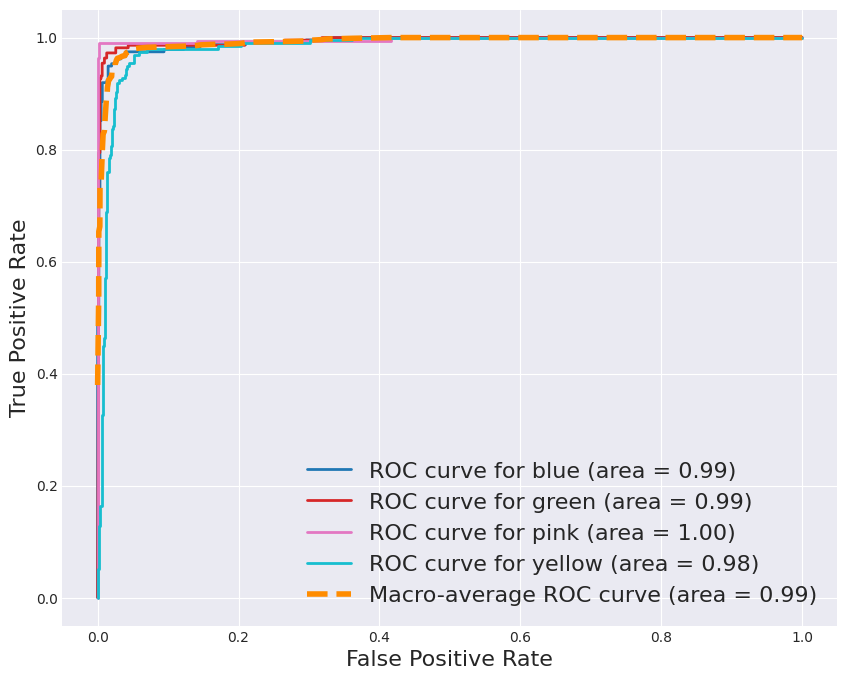

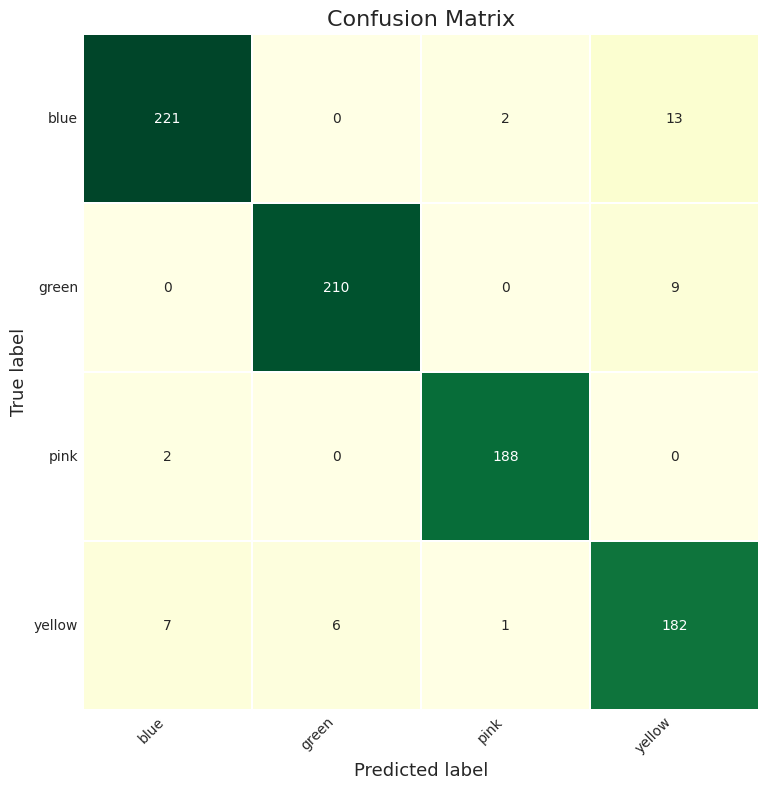

Classification Report:
              precision    recall  f1-score   support

        blue       0.96      0.94      0.95       236
       green       0.97      0.96      0.97       219
        pink       0.98      0.99      0.99       190
      yellow       0.89      0.93      0.91       196

    accuracy                           0.95       841
   macro avg       0.95      0.95      0.95       841
weighted avg       0.95      0.95      0.95       841

Overall Accuracy: 0.9524
Overall Precision: 0.9531
Overall Recall: 0.9524
Overall F1 Score: 0.9526
Cohen's Kappa: 0.9365


In [45]:
!pip install seaborn
import seaborn as sns
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from matplotlib.cm import get_cmap
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
from sklearn.preprocessing import label_binarize



test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
all_targets = []
all_probs = []
all_preds = []

# Set model to evaluation mode
model.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    
    # Make predictions
    with torch.no_grad():
        output = model(data)
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.cpu().numpy())  # Collect predictions

        # Collect target values
        all_targets.extend(target.cpu().numpy())   

        # Collect probabilities
        probs = torch.nn.functional.softmax(output, dim=1)
        all_probs.extend(probs.cpu().numpy())

# Convert the lists to numpy arrays
all_targets = np.array(all_targets)
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)

all_targets_one_hot = label_binarize(all_targets, classes=np.arange(len(classes)))

# Ensure that all_targets_one_hot is a 2D array
if all_targets_one_hot.ndim == 1:
    all_targets_one_hot = np.expand_dims(all_targets_one_hot, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(all_targets_one_hot[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

cmap = plt.get_cmap('tab10')  # You can choose a different colormap if you prefer
plt.style.use('seaborn-darkgrid')  # Change the style to 'seaborn-darkgrid'
plt.figure(figsize=(10, 8))
colors = cycle([cmap(i) for i in np.linspace(0, 1, len(classes))])

for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {classes[i]} (area = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(all_targets_one_hot.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= len(classes)

# Customize line styles and colors
plt.plot(all_fpr, mean_tpr,
         label=f'Macro-average ROC curve (area = {auc(all_fpr, mean_tpr):.2f})',
         color='darkorange', linestyle='--', linewidth=4)  # Change color to 'darkorange'

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
#plt.title('ROC of four classes', fontsize=16)
plt.legend(loc='lower right', fontsize=16)
plt.grid(True)
plt.show()


confusion_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(len(classes)))
# Plot customized confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mat, annot=True, fmt=".0f", cmap="YlGn", linewidths=.10, square=True, cbar=False,
            xticklabels=classes, yticklabels=classes)
    
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted label', fontsize=13)
plt.ylabel('True label', fontsize=13)
    
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
    
plt.tight_layout()
plt.show()




# Classification Report
class_report = classification_report(all_targets, all_preds, target_names=classes)
print("Classification Report:")
print(class_report)






from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_targets, all_preds)
print('Overall Accuracy: {:.4f}'.format(overall_accuracy))

# Calculate precision, recall, and F1-score
overall_precision = precision_score(all_targets, all_preds, average='weighted')
overall_recall = recall_score(all_targets, all_preds, average='weighted')
overall_f1 = f1_score(all_targets, all_preds, average='weighted')
cohen_kappa = cohen_kappa_score(all_targets, all_preds)


print('Overall Precision: {:.4f}'.format(overall_precision))
print('Overall Recall: {:.4f}'.format(overall_recall))
print('Overall F1 Score: {:.4f}'.format(overall_f1))
print('Cohen\'s Kappa: {:.4f}'.format(cohen_kappa))

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (4).

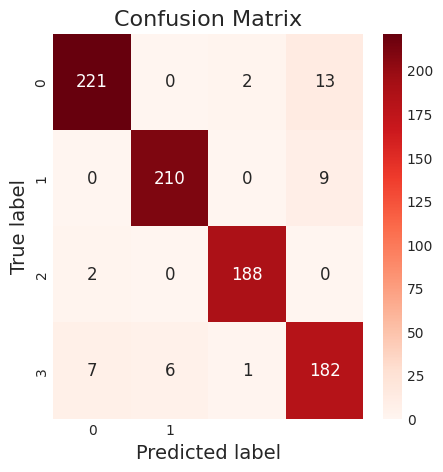

In [46]:

# Confusion Matrix
confusion_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(len(classes)))

# Plot the Confusion Matrix using Seaborn
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_mat, annot=True, fmt=".0f", cmap="Reds", annot_kws={"size": 12})  # Adjust the font size here
plt.title('Confusion Matrix', fontsize=16)  # Adjust the title font size
plt.xlabel('Predicted label', fontsize=14)  # Adjust the x-axis label font size
plt.ylabel('True label', fontsize=14)  # Adjust the y-axis label font size

# Set ticks and tick labels
tick_labels = classes
plt.xticks(np.arange(2) + 0.5, tick_labels, rotation=90, ha='right', fontsize=12)  # Adjust x-axis tick label font size
plt.yticks(np.arange(2) + 0.5, tick_labels, rotation=360, ha='right', fontsize=12)  # Adjust y-axis tick label font size

plt.show()

# Classification Report
class_report = classification_report(all_targets, all_preds, target_names=classes)
print("Classification Report:")
print(class_report)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_targets, all_preds)
print('Overall Accuracy: {:.4f}'.format(overall_accuracy))

# Calculate precision, recall, and F1-score
overall_precision = precision_score(all_targets, all_preds, average='weighted')
overall_recall = recall_score(all_targets, all_preds, average='weighted')
overall_f1 = f1_score(all_targets, all_preds, average='weighted')

print('Overall Precision: {:.4f}'.format(overall_precision))
print('Overall Recall: {:.4f}'.format(overall_recall))
print('Overall F1 Score: {:.4f}'.format(overall_f1))


# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_targets, all_preds)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# New design for ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.fill_between(fpr, tpr, color='red', alpha=0.3)  # Fill area under the curve

# Adding grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize x and y-axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)

plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)

# Adding legend with a white background
legend = plt.legend(loc="lower right", fontsize=12)
legend.get_frame().set_facecolor('white')

# Adding a shadow behind the legend for better visibility
legend.get_frame().set_linewidth(0.7)
legend.get_frame().set_edgecolor('black')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you already have the fpr, tpr, and roc_auc calculated

# New design for ROC Curve
plt.figure(figsize=(10, 6))

# Plotting the ROC curve with a dashed line style
plt.plot(fpr, tpr, color='green', linestyle='dashed', linewidth=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))

# Plotting a shaded area under the ROC curve
plt.fill_between(fpr, tpr, color='green', alpha=0.3)

# Adding labels and title with a different color
plt.xlabel('False Positive Rate', fontsize=14, color='darkblue')
plt.ylabel('True Positive Rate', fontsize=14, color='darkblue')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, color='darkblue')

# Customizing x and y-axis ticks
plt.xticks(fontsize=12, color='darkblue')
plt.yticks(fontsize=12, color='darkblue')

# Adding a legend with a frame
plt.legend(loc="lower right", fontsize=12, frameon=True, facecolor='lightgray', edgecolor='black')

# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you already have the fpr, tpr, and roc_auc calculated

# New design for ROC Curve
plt.figure(figsize=(10, 6))

# Plotting the ROC curve with a bold line style and marker
plt.plot(fpr, tpr, color='purple', linestyle='-', linewidth=3, marker='o', markersize=8, label='ROC curve (AUC = {:.2f})'.format(roc_auc))

# Adding a gradient color fill under the ROC curve
plt.fill_between(fpr, tpr, color='purple', alpha=0.2)

# Adding labels and title with a unique font style
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold', color='darkred')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold', color='darkred')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold', color='darkred')

# Customizing x and y-axis ticks
plt.xticks(fontsize=12, color='darkred')
plt.yticks(fontsize=12, color='darkred')

# Adding a legend with rounded corners and a shadow
legend = plt.legend(loc="lower right", fontsize=12, fancybox=True, framealpha=0.7, edgecolor='black', facecolor='lightyellow', shadow=True)

# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you already have the fpr, tpr, and roc_auc calculated

# New design for ROC Curve
plt.figure(figsize=(10, 6))

# Plotting the ROC curve with a gradient color
plt.plot(fpr, tpr, color='darkcyan', linewidth=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.fill_between(fpr, tpr, color='darkcyan', alpha=0.2)

# Adding labels and title with a distinctive font style
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold', color='navy')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold', color='navy')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold', color='navy')

# Customizing x and y-axis ticks
plt.xticks(fontsize=12, color='navy')
plt.yticks(fontsize=12, color='navy')

# Adding a legend with a frame and shadow
plt.legend(loc="lower right", fontsize=12, frameon=True, edgecolor='black', shadow=True)

# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customizing the background color
plt.gca().set_facecolor('lightgray')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()


# **For MultiClass**

In [ ]:
import torch
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

# Boxplot

In [ ]:
import matplotlib.pyplot as plt

# Dummy data for model names and accuracy
model_names = ['Densenet201', 'InceptionV3', 'MobilenetV2','Resnet50', 'VGG16','Xception71', 'ViT', 'DeiT']
accuracy_data = [
    [0.88, 0.84, 0.98, 0.75],
    [0.58, 0.78, 0.92, 0.65],
    [0.92, 0.86, 0.94, 0.71],
    [0.77, 0.75, 0.96, 0.72],
    [0.91, 0.90, 0.98, 0.92],
    [0.87, 0.96, 0.93, 0.64],
    [0.92, 0.96, 0.99, 0.75],
    [0.94, 0.96, 1.00, 0.92]
]


# Create a box plot with model names
fig, ax = plt.subplots(figsize=(10, 6))  # Change the figsize to your desired size
box = ax.boxplot(accuracy_data, patch_artist=True)  # patch_artist enables coloring

# Customize box colors and other properties
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightpink', 'lightcyan', 'lightseagreen']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Set font size for labels and title
ax.tick_params(axis='x', labelsize=10)  # X-axis label font size
ax.tick_params(axis='y', labelsize=10)  # Y-axis label font size
ax.set_title('Model Accuracy Box Plot', fontsize=10)  # Title font size
ax.set_ylabel('Accuracy', fontsize=10)

# Set x-tick positions and labels
ax.set_xticks(range(1, len(model_names) + 1))
ax.set_xticklabels(model_names, fontsize=10)

# Display the plot
plt.show()


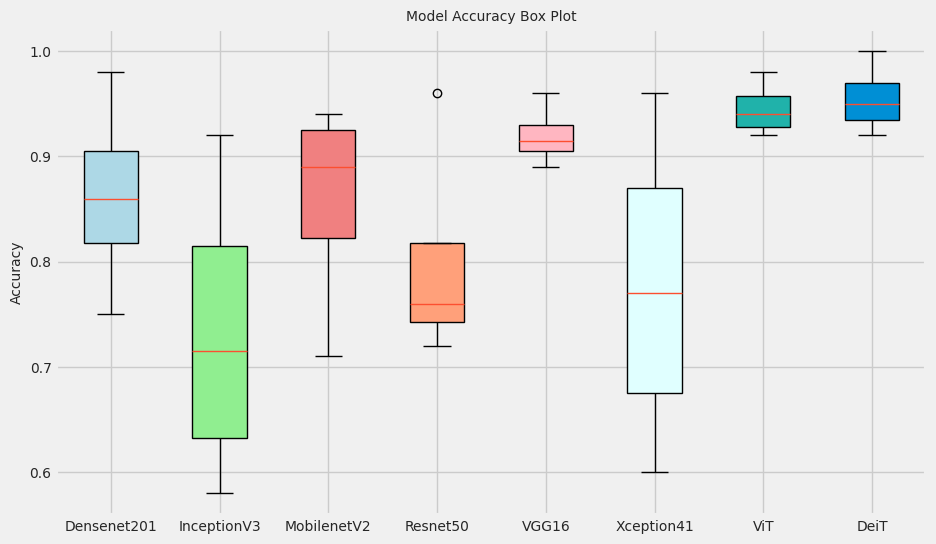

In [47]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')  # Set the style to 'fivethirtyeight'

# Dummy data for model names and accuracy
model_names = ['Densenet201', 'InceptionV3', 'MobilenetV2', 'Resnet50', 'VGG16', 'Xception41', 'ViT', 'DeiT']
accuracy_data = [
    [0.88, 0.84, 0.98, 0.75],
    [0.58, 0.78, 0.92, 0.65],
    [0.92, 0.86, 0.94, 0.71],
    [0.77, 0.75, 0.96, 0.72],
    [0.91, 0.92, 0.96, 0.89],
    [0.70, 0.84, 0.96, 0.60],
    [0.93, 0.95, 0.98, 0.92],
    [0.94, 0.96, 1.00, 0.92]
]

# Create a box plot with model names
fig, ax = plt.subplots(figsize=(10, 6))  # Change the figsize to your desired size
box = ax.boxplot(accuracy_data, patch_artist=True)  # patch_artist enables coloring

# Customize box colors and other properties
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightpink', 'lightcyan', 'lightseagreen']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Set font size for labels and title
ax.tick_params(axis='x', labelsize=10)  # X-axis label font size
ax.tick_params(axis='y', labelsize=10)  # Y-axis label font size
ax.set_title('Model Accuracy Box Plot', fontsize=10)  # Title font size
ax.set_ylabel('Accuracy', fontsize=10)

# Set x-tick positions and labels
ax.set_xticks(range(1, len(model_names) + 1))
ax.set_xticklabels(model_names, fontsize=10)

# Display the plot
plt.show()


In [ ]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have a list of model file paths
model_paths = ['model1.pt', 'model2.pt', 'model3.pt', 'model4.pt', 'model5.pt', 'model6.pt']

# Assuming you have a test_loader and criterion defined
# (replace this with your actual test_loader and criterion)
# test_loader = ...
# criterion = ...

# List to store results for each model
all_fprs = []
all_tprs = []
all_roc_aucs = []

for model_path in model_paths:
    # Load the model
    model = torch.load(model_path)
    model.eval()

    # Lists to store predictions and targets for each model
    all_preds = []
    all_targets = []

    # Evaluate the model on the test set
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
        _, pred = torch.max(output, 1)
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    # Calculate ROC curve and AUC for each model
    fpr, tpr, _ = roc_curve(all_targets, all_preds)
    roc_auc = auc(fpr, tpr)

    # Append results to the lists
    all_fprs.append(fpr)
    all_tprs.append(tpr)
    all_roc_aucs.append(roc_auc)

# Plot ROC curves for each model
plt.figure(figsize=(8, 8))
for i in range(len(model_paths)):
    plt.plot(all_fprs[i], all_tprs[i], lw=2, label=f'Model {i+1} (AUC = {:.2f})'.format(all_roc_aucs[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multiple Models')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have a list of model file paths
model_paths = ['model1.pt', 'model2.pt', 'model3.pt', 'model4.pt', 'model5.pt', 'model6.pt']

# Assuming you have a test_loader and criterion defined
# (replace this with your actual test_loader and criterion)
# test_loader = ...
# criterion = ...

# List to store results for each model
all_fprs = []
all_tprs = []
all_roc_aucs = []

for model_path in model_paths:
    # Load the model
    model = torch.load(model_path)
    model.eval()

    # Lists to store predictions and targets for each model
    all_preds = []
    all_targets = []

    # Evaluate the model on the test set
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
        _, pred = torch.max(output, 1)
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    # Calculate ROC curve and AUC for each model
    fpr, tpr, _ = roc_curve(all_targets, all_preds)
    roc_auc = auc(fpr, tpr)

    # Append results to the lists
    all_fprs.append(fpr)
    all_tprs.append(tpr)
    all_roc_aucs.append(roc_auc)

# Plot ROC curves for each model
plt.figure(figsize=(8, 8))
for i in range(len(model_paths)):
    plt.plot(all_fprs[i], all_tprs[i], lw=2, label=f'Model {i+1} (AUC = {:.2f})'.format(all_roc_aucs[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multiple Models')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Dummy data for model names and accuracy
model_names = ['VGG-16', 'VGG-19', 'Resnet34', 'Efficientnet', 'DeiT']
accuracy_data = [0.85, 0.92, 0.78, 0.88, 0.90]

# Create a box plot with Seaborn
plt.figure(figsize=(10, 6))  # Set the figure size

# Create a Seaborn box plot
sns.boxplot(x=model_names, y=accuracy_data, palette='Set2')

# Customize other properties
plt.title('Model Accuracy Box Plot', fontsize=16)  # Title font size
plt.ylabel('Accuracy', fontsize=14)  # Y-axis label font size

# Display the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Dummy data for model names, training accuracy, and validation accuracy
model_names = ['VGG-16', 'VGG-19', 'Resnet34', 'Efficientnet', 'DeiT']
training_accuracy = [random.uniform(0.7, 0.9) for _ in range(len(model_names)]
validation_accuracy = [random.uniform(0.7, 0.9) for _ in range(len(model_names)]

# Create a box plot with Seaborn
plt.figure(figsize=(10, 6))  # Set the figure size

# Create Seaborn box plots for training and validation accuracy with different colors
sns.boxplot(x=model_names, y=training_accuracy, palette='Set2', label='Training', width=0.4)
sns.boxplot(x=model_names, y=validation_accuracy, palette='Set1', label='Validation', width=0.4)

# Customize other properties
plt.title('Model Accuracy Box Plot', fontsize=16)  # Title font size
plt.ylabel('Accuracy', fontsize=14)  # Y-axis label font size

# Display the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend()  # Display legend for training and validation
plt.show()


In [ ]:
sns.boxplot(data=titanic, x="age", y="class")

In [ ]:
import matplotlib.pyplot as plt

# AUC results for each model
models = ['DeiT', 'Densenet201', 'Resnet152', 'VGG-16', 'VGG-19', 'ViT']
auc_scores = [1.00, 0.98, 0.98, 0.97, 0.97, 0.99]

# Plotting AUC-ROC curves
plt.figure(figsize=(12, 6))

# Plotting each model with a range of x-values
x_values = range(1, len(models) + 1)
for x, model, auc_score in zip(x_values, models, auc_scores):
    plt.scatter(x, auc_score, s=100, label=f'{model} (AUC = {auc_score:.2f})')

# Adding labels and legend
plt.xlabel('Models', fontsize=14)
plt.ylabel('AUC Score', fontsize=14)
plt.title('AUC-ROC Curve', fontsize=16)
plt.xticks(x_values, models, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=9, loc='lower right')

# Display the plot
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# AUC results for each model
models = ['DeiT', 'Densenet201', 'Resnet152', 'VGG-16', 'VGG-19', 'ViT']
auc_scores = [1.00, 0.98, 0.98, 0.97, 0.97, 0.99]

# Plotting AUC-ROC curves
plt.figure(figsize=(10, 6))

# Plotting each model with a range of x-values
for model, auc_score in zip(models, auc_scores):
    fpr, tpr, _ = roc_curve([1.00, 0.98, 0.98, 0.97, 0.97, 0.99], [0, 0.2, 0.8])  # Replace with your actual data
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{model} (AUC = {roc_auc:.2f})')

# Adding labels and legend
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2, label='Random Guess')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(fontsize=12, loc='lower right')

# Display the plot
plt.tight_layout()
plt.show()
